In [1]:
import os
import torch
import torch.nn as nn
import json

from config import get_config
from train_utils.gpu_utils import get_device_summary
from data.loader import get_dataloaders
from models.model import create_model
from train_utils.resume import init_resume_state
from train_utils.resume import fill_trackers_from_history
from train_utils.training_loop import run_training_loop
from train_utils.scheduler_utils import create_scheduler
from train_utils.training_summary import finalize_training_summary
from train_utils.training_summary import print_best_model_summary
from train_utils.plot_metrics import plot_train_val_metrics
from train_utils.plot_metrics import plot_loss_accuracy
from train_utils.plot_metrics import plot_confusion_matrices


In [ ]:
# cfg=get_config(config_path="config/convnext_fb_in22k_ft_in1k_bs512_ep50_lr1e-04_ds1000.yml")
# cfg=get_config(config_path="config/convnext_fb_in1k_bs512_ep50_lr1e-04_ds1000.yml")
# cfg=get_config(config_path="config/convnext_gaussian_bs512_ep50_lr1e-04_ds1000.yml")
# cfg=get_config(config_path="config/efficientnet_bs512_ep50_lr1e-01_ds1000_sched-RLRP.yml")
# cfg=get_config(config_path="config/vit_" \
# "bs512_ep50_lr1e-04_ds1000.yml")
# cfg=get_config(config_path="config/mambaout_base_plus_rw_bs32_ep50_lr1e-04_ds1000-g1.yml")
# cfg=get_config(config_path="config/mambaout_base_plus_rw_bs16_ep50_lr1e-04_ds1008_g500_sched-RLRP.yml")

from experiments.exp_mamaba_vit_stack.models.hybrid_mamba_vit import create_model
# cfg=get_config(config_path="/home/arsalan/wsu-grid/ml-jet-param-predictor/" \
# "experiments/exp_mamaba_vit_stack/config/" \
# "hybrid_mambaout_base_plus_rw_ViT_tiny_patch16_224_bs64_ep1_lr1e-04_ds1008_g500_sched-RLRP.yml")
cfg=get_config()
print(json.dumps(vars(cfg), indent=2))

[INFO] Config Path: /home/arsalan/wsu-grid/ml-jet-param-predictor/experiments/exp_mamaba_vit_stack/config/hybrid_mambaout_base_plus_rw_ViT_tiny_patch16_224_bs64_ep1_lr1e-04_ds1008_g500_sched-RLRP.yml
[INFO] Detected native Ubuntu host: DS044955
[INFO] Using dataset root: /home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_7200000_balanced_unshuffled
[INFO] Using dataset_size from config: 1008
{
  "model_tag": "mambaout_base_plus_rw_ViT_tiny_patch16_224_in1k_g500",
  "backbone": [
    "mambaout_base_plus_rw",
    "vit_tiny_patch16_224"
  ],
  "batch_size": 64,
  "epochs": 1,
  "learning_rate": 0.0001,
  "patience": 12,
  "input_shape": [
    1,
    32,
    32
  ],
  "global_max": 121.79151153564453,
  "dataset_root_dir": "/home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_7200000_balanced_unshuffled",
 

In [4]:
os.makedirs(cfg.output_dir, exist_ok=True)
print(f"[INFO] Saving all outputs to: {cfg.output_dir}")

[INFO] Saving all outputs to: training_output/mambaout_base_plus_rw_ViT_tiny_patch16_224_in1k_g500_bs64_ep1_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau


In [5]:
device= get_device_summary()

=== NVIDIA-SMI ===
Wed Aug  6 16:26:20 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.247.01             Driver Version: 535.247.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070        Off | 00000000:01:00.0  On |                  N/A |
| 30%   38C    P0              45W / 220W |    544MiB /  8192MiB |     22%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+------

In [6]:
# Data
train_loader, val_loader, test_loader = get_dataloaders(cfg, device=device)

[INFO] Training samples: 806
[INFO] Validation samples: 101
[INFO] Test samples: 101
[INFO] Length of training dataloader: 13
[INFO] Length of validation dataloader: 2
[INFO] Length of test dataloader: 2


In [7]:
# Model and optimizer
model, optimizer = create_model(cfg.backbone, cfg.input_shape, cfg.learning_rate)
model.to(device)

Using Hybrid Mamba ➝ ViT model: mambaout_base_plus_rw → vit_tiny_patch16_224


MambaToViTClassifier(
  (input_proj): Conv2d(1, 3, kernel_size=(1, 1), stride=(1, 1))
  (mamba): FeatureListNet(
    (stem): Stem(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): SiLU()
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
    )
    (stages_0): MambaOutStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): GatedConvBlock(
          (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (fc1): Linear(in_features=128, out_features=768, bias=True)
          (act): SiLU()
          (conv): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (fc2): Linear(in_features=384, out_features=128, bias=True)
          (ls): LayerScale()
          (drop_path): Identity()
        )
        (1): GatedConvBlock(
          (norm): LayerNorm((128,), eps=1e-06, elementwis

In [8]:
if torch.cuda.device_count() > 1:
    print(f"Parallelizing model across {torch.cuda.device_count()} GPUs")
    model = torch.nn.DataParallel(model)
elif torch.cuda.device_count() == 1:
    print("No parallelization, using single GPU")
elif torch.cuda.device_count() == 0:
    print("No GPU available, using CPU")

No parallelization, using single GPU


In [9]:
scheduler = create_scheduler(optimizer, cfg, train_loader=train_loader)

In [10]:
criterion = {
    # 'energy_loss_output': nn.BCELoss(),
    'energy_loss_output': nn.BCEWithLogitsLoss(),
    'alpha_output': nn.CrossEntropyLoss(),
    'q0_output': nn.CrossEntropyLoss()
}
print(f"[INFO] Loss functions:{criterion}")

[INFO] Loss functions:{'energy_loss_output': BCEWithLogitsLoss(), 'alpha_output': CrossEntropyLoss(), 'q0_output': CrossEntropyLoss()}


In [11]:
print(f"[INFO] Init Training Trackers")
train_loss_energy_list, train_loss_alpha_list, train_loss_q0_list, train_loss_list = [], [], [],[]
train_acc_energy_list, train_acc_alpha_list, train_acc_q0_list, train_acc_list = [], [], [], []

print(f"[INFO] Init Validation Trackers")
val_loss_energy_list, val_loss_alpha_list,val_loss_q0_list,val_loss_list = [], [], [], []
val_acc_energy_list, val_acc_alpha_list,val_acc_q0_list ,val_acc_list = [],[],[],[]

[INFO] Init Training Trackers
[INFO] Init Validation Trackers


In [12]:
model, optimizer, start_epoch, best_acc, early_stop_counter, best_epoch, best_metrics, training_summary, all_epoch_metrics,summary_status = init_resume_state( model, optimizer, device,cfg)

[INFO] Init Resume/Training Parameters
[INFO] Starting fresh training run by initializing training summary
[INFO] 📄 Training summary saved to: training_output/mambaout_base_plus_rw_ViT_tiny_patch16_224_in1k_g500_bs64_ep1_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau/training_summary.json


In [13]:
fill_trackers_from_history(
    all_epoch_metrics,
    train_loss_energy_list, train_loss_alpha_list, train_loss_q0_list, train_loss_list,
    train_acc_energy_list, train_acc_alpha_list, train_acc_q0_list, train_acc_list,
    val_loss_energy_list, val_loss_alpha_list, val_loss_q0_list, val_loss_list,
    val_acc_energy_list, val_acc_alpha_list, val_acc_q0_list, val_acc_list,
    summary_status, best_epoch
)

In [14]:
# for testing
# train_metrics = train_one_epoch(train_loader, model, criterion, optimizer, device)
# print(f"[INFO] Training metrics: {train_metrics}")

In [15]:
best_epoch,best_acc,best_metrics=run_training_loop(
                      cfg,train_loader,val_loader,
                      device, model,criterion,
                      optimizer,scheduler,
                      start_epoch,early_stop_counter,
                      best_acc,best_metrics,best_epoch,
                      train_loss_list,
                        train_loss_energy_list,
                        train_loss_alpha_list,
                        train_loss_q0_list,
                        train_acc_list,
                        train_acc_energy_list,
                        train_acc_alpha_list,
                        train_acc_q0_list,
                        val_loss_list,
                        val_loss_energy_list,
                        val_loss_alpha_list,
                        val_loss_q0_list,
                        val_acc_list,
                        val_acc_energy_list,
                        val_acc_alpha_list,
                        val_acc_q0_list,
                        all_epoch_metrics)

[INFO] Epoch 1/1


Training:   0%|          | 0/13 [00:00<?, ?it/s]

input proj
mamba
flatten if [B, C, 1, 1]
reshape to image
vit forward features


Training:   8%|▊         | 1/13 [00:02<00:32,  2.70s/it]

input proj
mamba
flatten if [B, C, 1, 1]
reshape to image
vit forward features


Training:  15%|█▌        | 2/13 [00:04<00:26,  2.44s/it]

input proj
mamba
flatten if [B, C, 1, 1]
reshape to image
vit forward features


Training:  23%|██▎       | 3/13 [00:07<00:23,  2.33s/it]

input proj
mamba
flatten if [B, C, 1, 1]
reshape to image
vit forward features


Training:  31%|███       | 4/13 [00:09<00:20,  2.26s/it]

input proj
mamba
flatten if [B, C, 1, 1]
reshape to image
vit forward features


Training:  38%|███▊      | 5/13 [00:11<00:17,  2.24s/it]

input proj
mamba
flatten if [B, C, 1, 1]
reshape to image
vit forward features


Training:  46%|████▌     | 6/13 [00:13<00:15,  2.27s/it]

input proj
mamba
flatten if [B, C, 1, 1]
reshape to image
vit forward features


Training:  54%|█████▍    | 7/13 [00:21<00:24,  4.09s/it]

input proj
mamba
flatten if [B, C, 1, 1]
reshape to image
vit forward features


Training:  62%|██████▏   | 8/13 [00:23<00:17,  3.51s/it]

input proj
mamba
flatten if [B, C, 1, 1]
reshape to image
vit forward features


Training:  69%|██████▉   | 9/13 [00:26<00:12,  3.07s/it]

input proj
mamba
flatten if [B, C, 1, 1]
reshape to image
vit forward features


Training:  77%|███████▋  | 10/13 [00:28<00:08,  2.80s/it]

input proj
mamba
flatten if [B, C, 1, 1]
reshape to image
vit forward features


Training:  85%|████████▍ | 11/13 [00:30<00:05,  2.63s/it]

input proj
mamba
flatten if [B, C, 1, 1]
reshape to image
vit forward features


input proj
mamba
flatten if [B, C, 1, 1]
reshape to image
vit forward features


input proj
mamba
flatten if [B, C, 1, 1]
reshape to image
vit forward features
input proj
mamba
flatten if [B, C, 1, 1]
reshape to image
vit forward features
[INFO] Epoch 1: Energy Acc =0.7426, αs Acc = 0.3168, Q0 Acc = 0.2574, Total Acc = 0.0792
[INFO] Epoch 1: Energy Loss =0.5734, αs Loss = 1.1279, Q0 Loss = 1.4175, Total Loss = 3.1189
📉 Current LR: 0.0001
[INFO] Epoch 1: Saving metrics to disk
💾 Last model saved at epoch 1
✅ Best model saved at epoch 1 with total accuracy: 0.0792


In [16]:
finalize_training_summary(
    summary=training_summary,
    best_epoch=best_epoch,
    best_acc=best_acc,
    best_metrics=best_metrics,
    output_dir=cfg.output_dir
)
print_best_model_summary(
    best_epoch=best_epoch,
    best_acc=best_acc,
    best_metrics=best_metrics
)

[INFO] 📄 Training summary saved to: training_output/mambaout_base_plus_rw_ViT_tiny_patch16_224_in1k_g500_bs64_ep1_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau/training_summary.json

🏁 Best Model @ Epoch 1
Total Accuracy: 0.0792

🔹 ENERGY Task
  Accuracy : 0.7426
  Precision: 0.3713
  Recall   : 0.5000
  F1-Score : 0.4261
  Confusion Matrix:
[[0, 26], [0, 75]]

🔹 ALPHA Task
  Accuracy : 0.3168
  Precision: 0.1056
  Recall   : 0.3333
  F1-Score : 0.1604
  Confusion Matrix:
[[0, 0, 34], [0, 0, 35], [0, 0, 32]]

🔹 Q0 Task
  Accuracy : 0.2574
  Precision: 0.0644
  Recall   : 0.2500
  F1-Score : 0.1024
  Confusion Matrix:
[[0, 0, 0, 26], [0, 0, 0, 24], [0, 0, 0, 25], [0, 0, 0, 26]]


📊 Plots saved to:
 - training_output/mambaout_base_plus_rw_ViT_tiny_patch16_224_in1k_g500_bs64_ep1_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau/loss_accuracy_plot.png
 - training_output/mambaout_base_plus_rw_ViT_tiny_patch16_224_in1k_g500_bs64_ep1_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau/loss_accuracy_plot.pdf


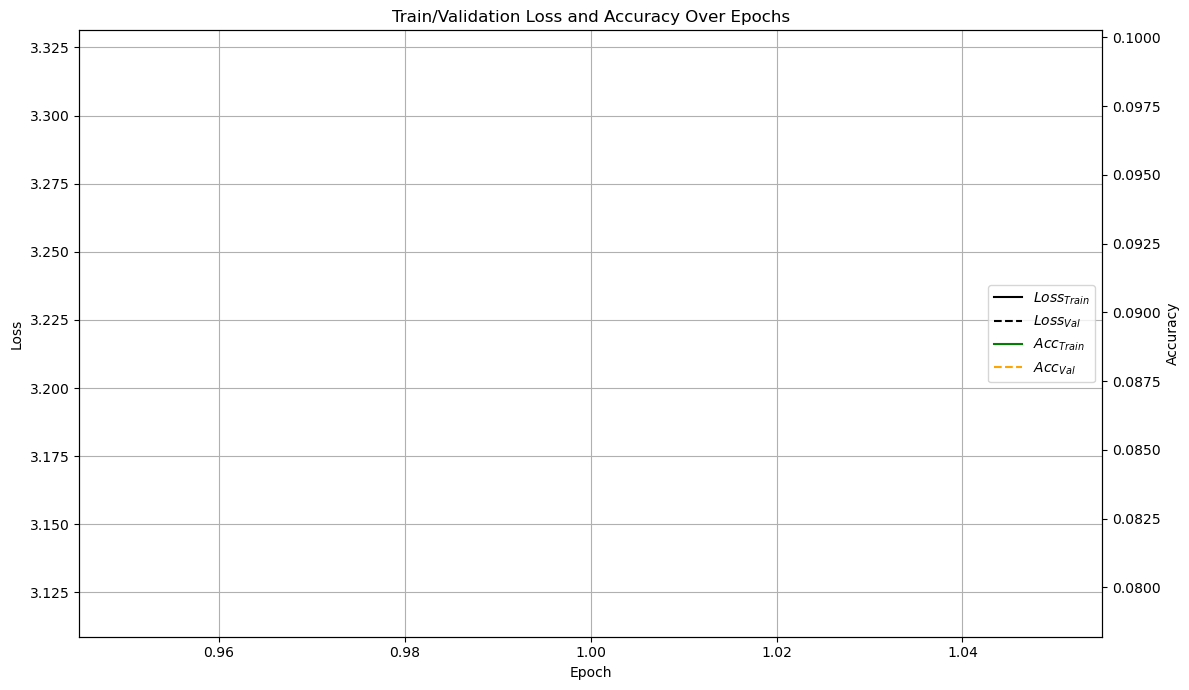

📉 Loss plot saved as:
  - training_output/mambaout_base_plus_rw_ViT_tiny_patch16_224_in1k_g500_bs64_ep1_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau/train_loss_and_accuracy_per_epoch_plot.png
  - training_output/mambaout_base_plus_rw_ViT_tiny_patch16_224_in1k_g500_bs64_ep1_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau/train_loss_and_accuracy_per_epoch_plot.pdf


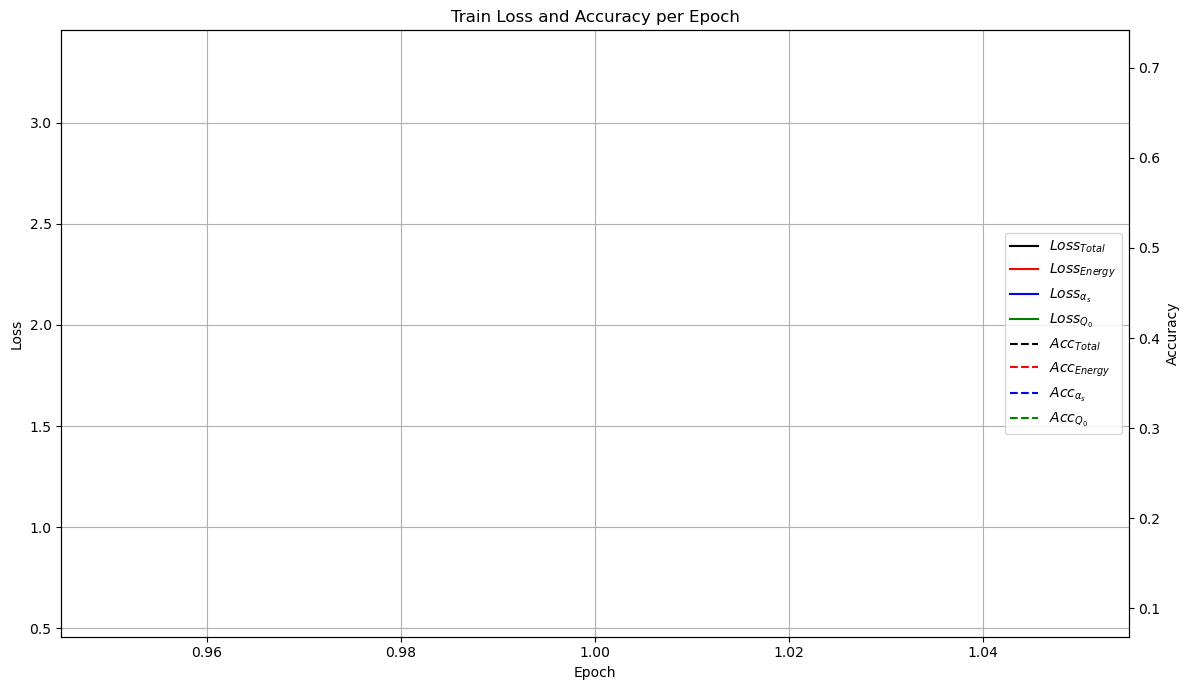

📉 Loss plot saved as:
  - training_output/mambaout_base_plus_rw_ViT_tiny_patch16_224_in1k_g500_bs64_ep1_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau/validation_loss_and_accuracy_per_epoch_plot.png
  - training_output/mambaout_base_plus_rw_ViT_tiny_patch16_224_in1k_g500_bs64_ep1_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau/validation_loss_and_accuracy_per_epoch_plot.pdf


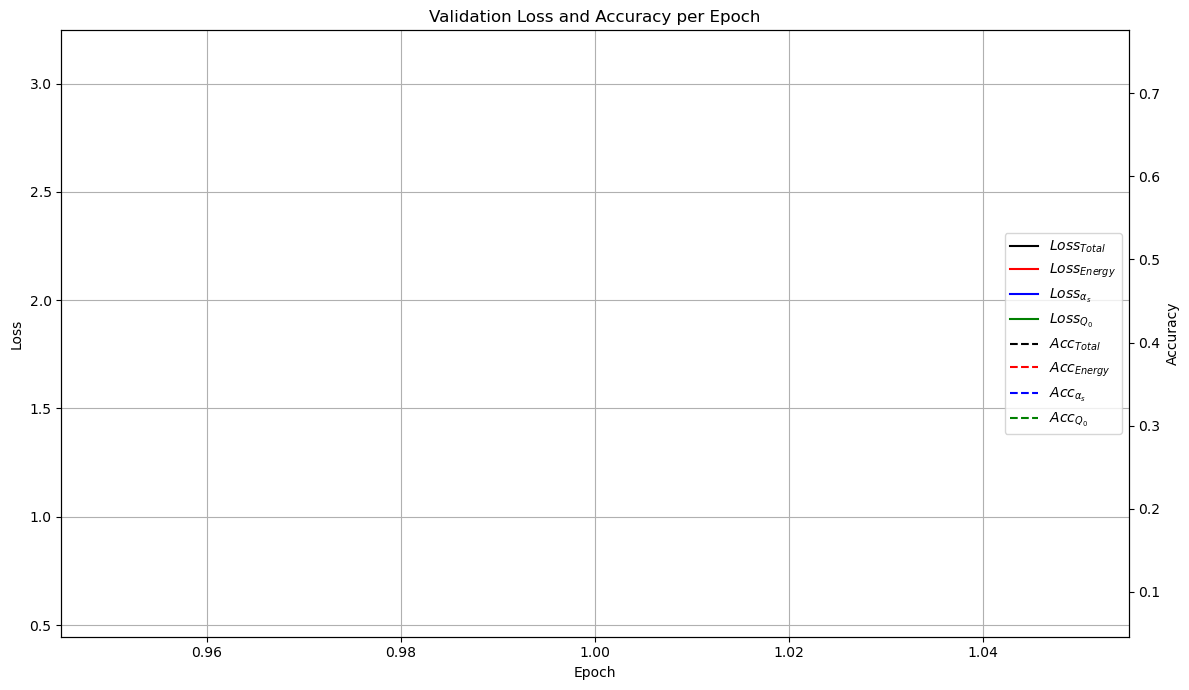

In [17]:
plot_train_val_metrics(train_loss_list, val_loss_list, train_acc_list, val_acc_list, cfg.output_dir)
plot_loss_accuracy(train_loss_list,
                    train_loss_energy_list,
                    train_loss_alpha_list,
                    train_loss_q0_list,
                    train_acc_list,
                    train_acc_energy_list,
                    train_acc_alpha_list,
                    train_acc_q0_list,
                    cfg.output_dir,
                    title="Train Loss and Accuracy per Epoch")
plot_loss_accuracy(val_loss_list,
                    val_loss_energy_list,
                    val_loss_alpha_list,
                    val_loss_q0_list,
                    val_acc_list,
                    val_acc_energy_list,
                    val_acc_alpha_list,
                    val_acc_q0_list,
                    cfg.output_dir,
                    title="Validation Loss and Accuracy per Epoch")

✅ Saved confusion matrix for energy:
 - training_output/mambaout_base_plus_rw_ViT_tiny_patch16_224_in1k_g500_bs64_ep1_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau/confusion_plots/confusion_matrix_energy.png
 - training_output/mambaout_base_plus_rw_ViT_tiny_patch16_224_in1k_g500_bs64_ep1_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau/confusion_plots/confusion_matrix_energy.pdf


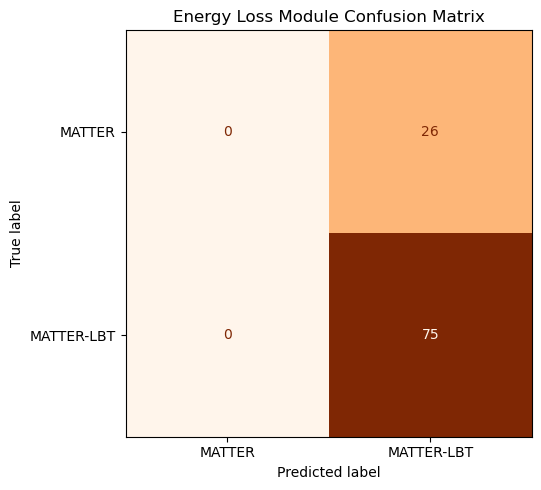

✅ Saved confusion matrix for alpha:
 - training_output/mambaout_base_plus_rw_ViT_tiny_patch16_224_in1k_g500_bs64_ep1_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau/confusion_plots/confusion_matrix_alpha.png
 - training_output/mambaout_base_plus_rw_ViT_tiny_patch16_224_in1k_g500_bs64_ep1_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau/confusion_plots/confusion_matrix_alpha.pdf


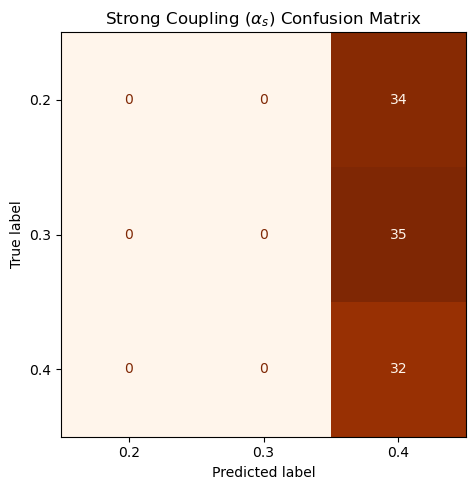

✅ Saved confusion matrix for q0:
 - training_output/mambaout_base_plus_rw_ViT_tiny_patch16_224_in1k_g500_bs64_ep1_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau/confusion_plots/confusion_matrix_q0.png
 - training_output/mambaout_base_plus_rw_ViT_tiny_patch16_224_in1k_g500_bs64_ep1_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau/confusion_plots/confusion_matrix_q0.pdf


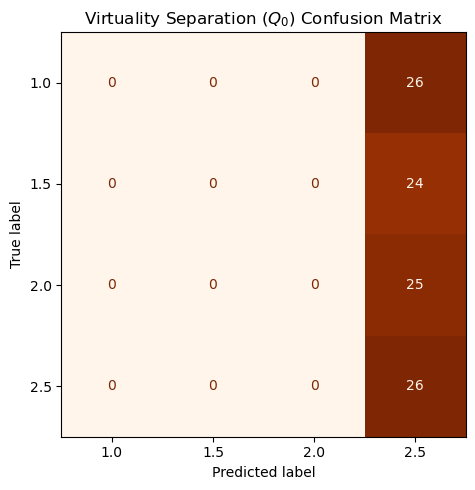

In [18]:
plot_confusion_matrices(best_metrics, output_dir=cfg.output_dir, color_map="Oranges")